## Import Packages + Setup

In [1]:
# Data Management
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import sqlite3

# Visualization
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

# Pre-processing
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree

# Evaluating model's performance
import sklearn.metrics as m
import math

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [2]:
# Set connection to SQL database and save datasets
conn = sqlite3.connect("Final_Project.sqlite")
election_results = pd.read_sql('select * from Election_Results',conn)
prev_pres = pd.read_sql('select * from Previous_Presidents',conn)
gdp = pd.read_sql('select * from Econ',conn)
states = pd.read_sql('select * from States',conn)
turnout = pd.read_sql('select * from Turnout',conn)
total_data = pd.read_sql('select * from Total_Data',conn)
conn.close()

# Set different key states
key_states = ['New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada', 'Wisconsin', 'New Hampshire', 'Michigan']
swing_states_overall = ['New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada']
swing_states_accurate = ['Ohio', 'Nevada', 'Pennsylvania', 'New Mexico', 'Wisconsin', 'New Hampshire', 'Michigan']

## Examine and change data

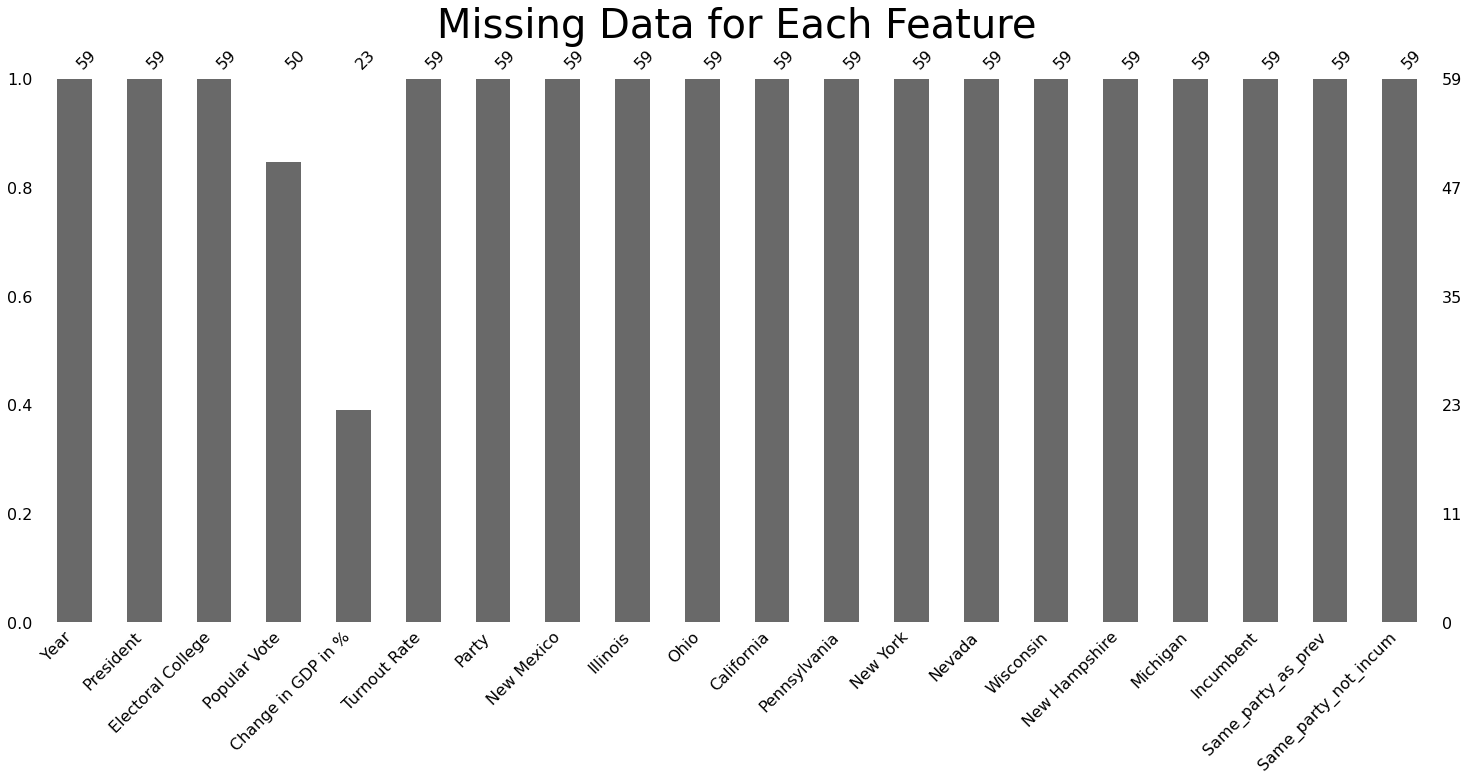

In [3]:
# Missing data bar graph
miss.bar(total_data)

# Add a title
plt.title('Missing Data for Each Feature', fontsize = 40)
# Save the plot
#plt.savefig('Missing_Data', dpi = 300)
plt.show()

In [4]:
# Make party a categorical variable: R is 0, D is 1, other is 2
# Ordered by how many times each party won
total_data.Party.replace({'R': 0, 'D': 1, 'DR': 2, 'W': 3, 'GW': 4, 'F': 5, 'Adams': 6}, inplace = True)

In [5]:
# Create a couple subsets of the data

# Popular vote as measure, needs to be once Popular Vote is measured
pop_vote_data = total_data[total_data['Popular Vote'].notna()]
# Once GDP started being measured
gdp_data = total_data[total_data['Change in GDP in %'].notna()]
# Only using overall swing states
swing_historic = total_data.drop(columns = ['Wisconsin', 'New Hampshire', 'Michigan'])
# Only using more accurate swing
swing_accurate = total_data.drop(columns = ['Illinois', 'California', 'New York'])

## Pipeline

In [6]:
# Set folds
fold_generator = KFold(n_splits=10, shuffle=True, random_state = 7777)
    
# Create Pipeline
pipe = Pipeline(steps = [('pre_process', pp.MinMaxScaler()), ('model', None)])
    
# Specify models and tuning parameters
search_space = [
        
    # Linear Model
    {'model' : [LM()]},
        
    # Bagging Model
    {'model': [Bag()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1,2,5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,4,5,6]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4,5],
     'model__n_estimators':[250,500,1000,1500,1750]}
]
    
# Search for best model
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator, 
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = 4)

In [7]:
# Total Data study using Electoral College share - ignore GDP
# Split Data 
y = total_data['Electoral College']
x = total_data.iloc[:,5:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.25, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Electoral_no_GDP = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -209.45161776999998
The best parameter is {'model': BaggingRegressor()}
The r^2 is 0.8711991082147864
The r^2 for the test data is -0.2617391523921737
The average distance of the predicted values from the true values is 5.939762856836503


In [8]:
# Data study using popular vote share as measure, ignore GDP
# Split Data 
y = pop_vote_data['Popular Vote']
x = pop_vote_data.iloc[:,5:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Popular_no_GDP = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -25.59701549336723
The best parameter is {'model': LinearRegression()}
The r^2 is 0.6540295960480315
The r^2 for the test data is 0.22796922538973075
The average distance of the predicted values from the true values is 3.168429479747558


In [9]:
# Data study that includes GDP, looking at Electoral College share
# Split Data 
y = gdp_data['Electoral College']
x = gdp_data.iloc[:,4:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Electoral_GDP = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -270.87061035
The best parameter is {'model': BaggingRegressor()}
The r^2 is 0.8784133539638446
The r^2 for the test data is -0.13244410152410246
The average distance of the predicted values from the true values is 5.953605541555842


In [10]:
# Data study that includes GDP, looking at Popular Vote share
# Split Data 
y = gdp_data['Popular Vote']
x = gdp_data.iloc[:,4:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Popular_GDP = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -31.225614999999994
The best parameter is {'model': BaggingRegressor()}
The r^2 is 0.680579576922635
The r^2 for the test data is -0.30682730263157865
The average distance of the predicted values from the true values is 2.778830689336794


In [11]:
swing_overall = total_data[['Electoral College', 'New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada']]
swing_accurate = total_data[['Electoral College', 'Ohio', 'Nevada', 'Pennsylvania', 'New Mexico', 'Wisconsin', 'New Hampshire', 'Michigan']]

In [12]:
# See which is more accurate, swing states overall or accurate swing states
# Split Data 
y = swing_overall['Electoral College']
x = swing_overall.iloc[:,1:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Overall_swing = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -327.7625940808106
The best parameter is {'model': BaggingRegressor()}
The r^2 is 0.4248491749166947
The r^2 for the test data is 0.3512758028163321
The average distance of the predicted values from the true values is 12.233160636222944


In [13]:
# Split Data 
y = swing_accurate['Electoral College']
x = swing_accurate.iloc[:,1:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)

print("The best score is", search.best_score_)
print("The best parameter is", search.best_params_)

pred_y = search.predict(train_x)
print("The r^2 is", m.r2_score(train_y,pred_y))

pred_y_test = search.predict(test_x)
print("The r^2 for the test data is", m.r2_score(test_y,pred_y_test))

print("The average distance of the predicted values from the true values is", math.sqrt(m.mean_squared_error(train_y,pred_y)))

# Create a dictionary for results
Accurate_swing = {'Best Parameter': search.best_params_, 'Best Score': search.best_score_, 'Train R^2':m.r2_score(train_y,pred_y), 'Test R^2': m.r2_score(test_y,pred_y_test), 'Standard Error of Train': math.sqrt(m.mean_squared_error(train_y,pred_y))}

The best score is -186.39447798877967
The best parameter is {'model': BaggingRegressor()}
The r^2 is 0.6472949985831525
The r^2 for the test data is 0.1801125341645594
The average distance of the predicted values from the true values is 9.579737613994881


In [14]:
# Create dataframe from results
df = pd.DataFrame([Electoral_no_GDP, Popular_no_GDP, Electoral_GDP, Popular_GDP, Overall_swing, Accurate_swing],
                  index=['Electoral w/out GDP', 'Popular w/out GDP', 'Electoral w/ GDP', 'Popular w/ GDP', 'Overall swing', 'Accurate swing'])

# Export dataframe
import dataframe_image as dfi
#dfi.export(df, 'Comparing_Results.png')

In [15]:
df

,Best Parameter,Best Score,Train R^2,Test R^2,Standard Error of Train
Electoral w/out GDP,{'model': BaggingRegressor()},-209.451618,0.871199,-0.261739,5.939763
Popular w/out GDP,{'model': LinearRegression()},-25.597015,0.654030,0.227969,3.168429
Electoral w/ GDP,{'model': BaggingRegressor()},-270.870610,0.878413,-0.132444,5.953606
Popular w/ GDP,{'model': BaggingRegressor()},-31.225615,0.680580,-0.306827,2.778831
Overall swing,{'model': BaggingRegressor()},-327.762594,0.424849,0.351276,12.233161
Accurate swing,{'model': BaggingRegressor()},-186.394478,0.647295,0.180113,9.579738


## Model Interpretation

In [16]:
# Look at data again
y = gdp_data['Electoral College']
x = gdp_data.iloc[:,4:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 777)

search.fit(train_x, train_y)
rf_mod = search.best_estimator_

In [17]:
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=25)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

vi_dat

,variable,vi,std,low,high
0,New York,0.213319,0.061796,0.089726,0.336912
1,California,0.193137,0.058136,0.076866,0.309409
2,Change in GDP in %,0.165055,0.056368,0.052318,0.277791
3,Turnout Rate,0.063219,0.036626,-0.010033,0.136471
4,Party,0.062883,0.038910,-0.014938,0.140704
5,New Hampshire,0.046573,0.016591,0.013392,0.079754
6,Pennsylvania,0.026900,0.012979,0.000942,0.052857
7,Incumbent,0.024803,0.024874,-0.024946,0.074552
8,Wisconsin,0.018127,0.009741,-0.001354,0.037609
9,New Mexico,0.017274,0.012214,-0.007154,0.041702


In [18]:
# Plot
var_importance = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Importance",x='', title="Variable Importance")
)
#var_importance.save("variable_importance.png", dpi=300)

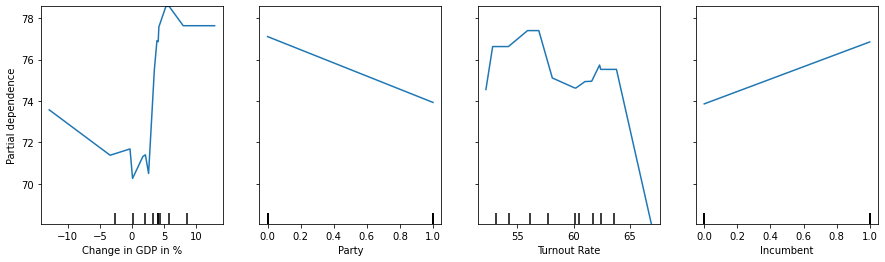

In [19]:
# Target specific features
features = ['Change in GDP in %','Party', 'Turnout Rate','Incumbent']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_x, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

#plt.savefig('Feature_dependence.png', dpi = 300)
plt.show()

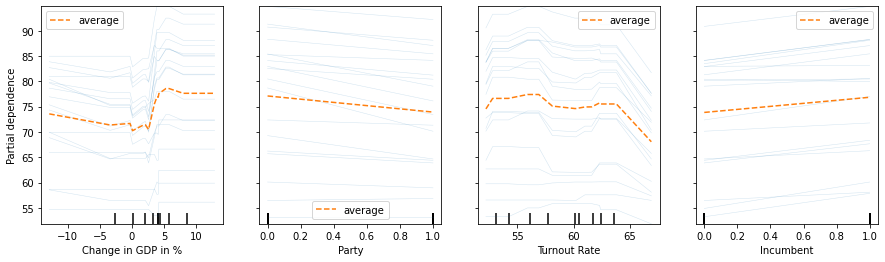

In [20]:
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_x,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

#plt.savefig('ice_plot.png', dpi = 300)
plt.show()